# Tutorial on Bayesian Optimization

[Bayesian optimization](https://en.wikipedia.org/wiki/Bayesian_optimization) is an optimization method that uses Bayes Theorem to _direct_ the search to find the minimum/maximum of an objective function. 

Let's start by recalling that Bayes Theorem is an approach for calculating the conditional probability of an event:
\begin{equation}
P(A|B) = \frac{P(B|A)P(A)}{P(B)}.
\end{equation}
The expression can be simplified by removing the normalization factor $P(B)$, which still allows us to achieve our goal of optimizing a quantity by describing the conditional probability as a proportional quantity. 
\begin{equation}
P(A|B) = P(B|A) P(A).
\end{equation}

We can devise specific samples $\{x_1, x_2, \cdots, x_n\}$ and evaluate them using the objective function $f(x_i)$ that returns the cost or outcome for the sample $x_i$. Samples and their outcome are collected sequentially and define our data $D$, e.g. $D = \{x_i, f(x_i), \cdots, x_n, f(x_n)\}$ and is used to define the prior. The likelihood function is defined as the probability of observing the data given the function $P(D|f)$. This likelihood function will change as more observations are collected.

\begin{equation}
P(f|D) = P(D|f) P(f)
\end{equation}
The posterior represents everything we know about the objective function, and it is an approximation of the objective function and can be used to estimate the value of $f()$ of different candidate samples. In this way, the posterior probability is a surrogate objective function. 

**Surrogate Function**: Bayesian approximation of the objective function that can be sampled efficiently.

The surrogate function gives us an estimate of the objective function, which can be used to direct future sampling. Sampling involves careful use of the posterior in a function known as the "acquisition" function, e.g. for acquiring more samples. We want to use our belief about the objective function to sample the area of the search space that is most likely to pay off (either as an exploration or exploitation). 

**Acquisition Function**: Technique by which the posterior is used to select the next sample from the search space. 

The acquisition function will optimize the conditional probability of locations in the search to generate the next sample. Once additional samples and their evaluation via the objective function $f()$ have been collected, they are added to data $D$ and the posterior is then updated. 

This process is repeated until the extrema of the objective function are located, a good enough result is located, or resources are exhausted. 

The Bayesian Optimization algorithm can be summarized as follows:

1. Select a sample by optimizing the acquisition function
2. Evaluate the sample with the objective function 
3. Update the data and, in turn, the surrogate function
4. Go to 1.


# How to perform Bayesian Optimization

We will now explore how Bayesian Optimization works by developing an implementation from scratch for a simple one-dimensional 
test function. 

First, we will define the test problem, then how to model the mapping of inputs to outputs with a surrogate function. 
Next, we will see how the surrogate function can be searched efficiently with an aqcuisition function before tying 
all of these elements together into the Bayesian Optimization procedure.

## Example Problem

We will use a multimodal problem with five peaks, calculated as
\begin{equation}
y = x^2 \sin^6(5 \pi x),
\end{equation}
where $x$ is a real value in the range [0, 1).

We will augment this function by adding Gaussian noise with a mean of zero and a standard deviation of 0.1. This will mean that the real evaluation will have a positive or negative random value added to it, making the function challenging to optimize.

The `objective()` function below implements this.

In [1]:
from numpy.random import normal
from math import sin
from math import pi

# objective function
def objective(x: float) -> float:
    return (x**2 * sin(5 * pi * x)**6.0)

We can test this function by first defining a grid-based sample of inputs from 0 to 1 with a step size of 0.01 across the domain.

In [2]:
from numpy import arange
# grid-based sample of the domain [0,1)
X = arange(0, 1, 0.01)
print(X)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99]


We can then evaluate these samples using the target function to see what the objective function looks like.

In [3]:
# sample the domain 
y = [objective(x) for x in X]
print(y)

[0.0, 1.4655297809619805e-09, 3.483005625052574e-07, 7.879943409141716e-06, 6.598300562505258e-05, 0.0003124999999999999, 0.0010093652949374528, 0.002451779358719597, 0.004736067977499789, 0.007519770412501646, 0.010000000000000002, 0.01123323728287283, 0.01065615294937453, 0.008456136971910446, 0.005495433272437245, 0.002812500000000001, 0.0010557280900008426, 0.00025303373836021753, 2.821234556292591e-05, 5.290562509272771e-07, 1.3493515170493364e-97, 6.462986334042298e-07, 4.2144368063136055e-05, 0.00046316556260399575, 0.0023753882025018902, 0.007812499999999996, 0.0189536372049366, 0.03647647250013438, 0.058016832724372414, 0.07807564094955408, 0.09, 0.08921604156066769, 0.07577708763999667, 0.05448954533970696, 0.03241184113743602, 0.015312499999999937, 0.00534462345562927, 0.001198626947457226, 0.00012573650306439859, 2.2290707968431933e-06, 3.454339883646301e-95, 2.4635555617971495e-06, 0.00015360054806481783, 0.0016188905959447766, 0.007983943680631343, 0.025312499999999964, 0

We would not know this in practice, but for out test problem, it is good to know the real best input and output of the function to see if the Bayesian Optimization algorithm can locate it.

In [4]:
from numpy import argmax
# find best result
ix = argmax(y)
print(f"Optima: x={X[ix]:.3}, y={y[ix]:.3}")

Optima: x=0.9, y=0.81


The global optima is an input with the value 0.9 that gives the score 0.81.

Finally, we can create a plot, first showing the evaluation as a scatter plot with input on the x-axis and score on the y-axis, then a line plot of the scores without any noise.

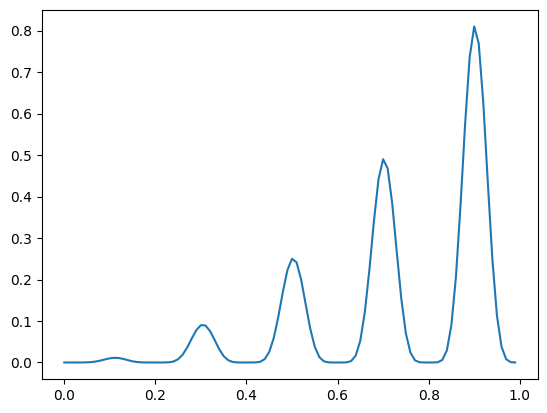

In [5]:
from matplotlib import pyplot

# plot the points
pyplot.plot(X, y)
# show the plot
pyplot.show()

## Surrogate Function 

The surrogate function is a technique used to best approximate the mapping of design parameters to an output score. It summarizes the conditional probability of an objective function ($f$), given the available data ($D$) or $P(f|D)$.

We use Gaussian Process (GP) construct a joint probability distribution over the variables, assuming a multivariate Gaussian distribution. As such, it is capable of efficient and effective summarization of a large number of functions and smooth transition as more observations are made available to the model.

This smooth structure and smooth transition to new functions based on data are desirable properties as we sample the domain, and the multivariate Gaussian basis to the model means that an estimate from the model will be a mean of a distribution with a standard deviation; that will be helpful later in the acquisition function.

We can fit a GP regression model using the [GaussianProcessRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html) scikit-learn implementation from a sample of inputs ($X$) and evaluations from the objective function ($y$).

First, the model must be defined. An important aspect in defining the GP model is the kernel. This controls the shape of the function at specific points based on distance measured between actual data observations. Many different kernel functions can be used, and some may offer better performance for specific datasets.

By default, a [Radial Basis Function](https://en.wikipedia.org/wiki/Radial_basis_function), or RBF, is used that can work well.

```python
# define the model
model = GaussianProcessRegressor()
```

Once defined, the model can be fit on the training dataset directly by calling the `fit()` function. 

```python
# fit the model
model.fit(X, y)
```

The model will estimate the cost for one or more samples provided to it.

The model is used by calling the `predict()` function. The result for a given sample will be a mean of the distribution at that point. We can also get the standard deviation of the distribution at that point in the function by specifying the argument `return_std=True`. For example:

```python
yhat = model.predict(X, return_std=True)
```

This function can result in warnings if the distribution is thin at a given point we are interested in sampling. Therefore, we silence all of the warnings when making a prediction. The `surrogate()` function below takes the fit model and one or more samples and returns the mean and standard deviation estimated costs without printing any warnings.

```python
# surrogate or approximation for the objective function
def surrogate(model, X):
    # catch any warning generated when making a prediction
    with catch_warnings():
        # ignore generated warnings
        simplefilter("ignore")
        return model.predict(X, return_std=True)
```

We can call this function any time to estimate the cost of one or more samples, such as when we want to optimize the acquisition function in the next section. For now, it is interesting to see what the surrogate function looks like across the domain after it is trained on a random sample. 

We achieve this by first fitting the GP model on a random sample of 100 data points and their real objective function values. We can then plot a scatter plot of these points. Next, we can perform a grid-based sample across the input domain and estimate the cost at each point using the surrogate function and plot the result as a line.

We would expect the surrogate function to have a crude approximation of the true objective function. The `plot()` function below creates this plot, given the random data sample of the objective function and the fit model.

```python
# plot real observations vs surrogate function
def plot(X, y, model):
    # scatter plot of inputs and real objective function
    pyplot.scatter(X, y)
    # line plot of surrogate function across domain
    Xsamples = asarray(arange(0, 1, 0.001))
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    ysamples, _ = surrogate(model, Xsamples)
    pyplot.plot(Xsamples, ysamples)
    # show the plot
    pyplot.show()
```

Tying this together, the complete example of fitting a Gaussian Process regression model and plotting the sample vs. the surrogate function is listed below.

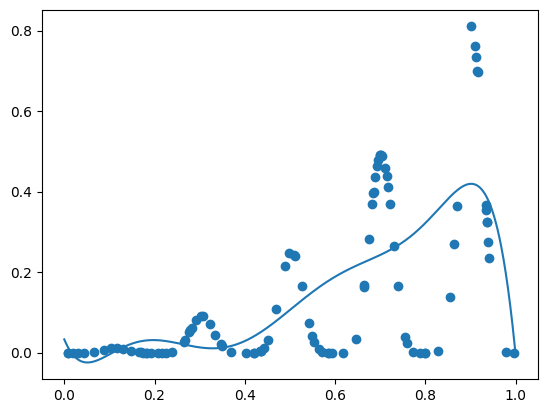

In [6]:
# example of a gaussian process surrogate function
from math import sin
from math import pi
from numpy import arange
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from matplotlib import pyplot
from warnings import catch_warnings
from warnings import simplefilter
from sklearn.gaussian_process import GaussianProcessRegressor
 
# objective function
def objective(x):
    return (x**2 * sin(5 * pi * x)**6.0)
 
# surrogate or approximation for the objective function
def surrogate(model, X):
    # catch any warning generated when making a prediction
    with catch_warnings():
        # ignore generated warnings
        simplefilter("ignore")
        return model.predict(X, return_std=True)
 
# plot real observations vs surrogate function
def plot(X, y, model):
    # scatter plot of inputs and real objective function
    pyplot.scatter(X, y)
    # line plot of surrogate function across domain
    Xsamples = asarray(arange(0, 1, 0.001))
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    ysamples, _ = surrogate(model, Xsamples)
    pyplot.plot(Xsamples, ysamples)
    # show the plot
    pyplot.show()
 
# sample the domain sparsely with noise
X = random(100)
y = asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot the surrogate function
plot(X, y, model)

Running the example first draws the random sample, evaluates it with the objective function, then fits the GP model.

The data samples are plotted as dots and the surrogate function is plotted as a line.

As we expected, the plot resembles a crude version of the underlying objective function, importantly with a peak around 0.9 where we know the true maxima is located.

Next, we must define a strategy for sampling the surrogate function.

## Acquisition Function

The surrogate function is used to test a range of candidate samples in the domain. Using the surrogate model results, candidate(s) can be selected and evaluated with the real, computationally expensive cost function.

This involves two pieces: the search strategy used to navigate the domain in response to the surrogate function and the acquisition function that is used to interpret and score the response from the surrogate function.

In this example, we will use a random search in order to keep the example simple. This involves first drawing a random sample of candidate samples from the domain, evaluating them with the acquisition function, then maximizing the acquisition function or choosing the candidate sample that gives the best score. The `opt_acquisition()` function below implements this.

```python
# optimize the acquisition function
def opt_acquisition(X, y, model):
    # random search, generate random samples
    Xsamples = random(100)
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    # calculate the acquisition function for each sample
    scores = acquisition(X, Xsamples, model)
    # locate the index of the largest scores
    ix = argmax(scores)
    return Xsamples[ix, 0]
```

The acquisition function is responsible for scoring or estimating the likelihood that a given candidate sample (input) is worth evaluating with the real objective function.

We could just use the surrogate score directly. Alternately, given that we have chosen a Gaussian Process model as the surrogate function, we can use the probabilistic information from this model in the acquisition function to calculate the probability that a given sample is worth evaluating.

There are many different types of probabilistic acquisition functions that can be used, each providing a different trade-off for how exploitative (greedy) and explorative they are.

Three common examples include:

* Probability of Improvement (PI).
* Expected Improvement (EI).
* Lower Confidence Bound (LCB).

The Probability of Improvement (PI) method is the simplest, whereas the Expected Improvement method is the most commonly used. In this exercise, we will use the simpler PI method, which is calculated as the normal cumulative probability of the normalized expected improvement. It is calculated as follows:

$\mathrm{PI} = \mathrm{cdf}((\mu – \mu_{best})/\mathrm{stdev})$


$\mathrm{cdf}()$ is the normal cumulative distribution function, $\mu$ is the mean of the surrogate function for a given sample $x$, $\mathrm{stdev}$ is the standard deviation of the surrogate function for a given sample $x$, and $\mu_{best}$ is the mean of the surrogate function for the best sample found so far.

We can add a very small number to the standard deviation to avoid a divide by zero error.

The `acquisition()` function below implements this given the current training dataset of input samples, an array of new candidate samples, and the fit GP model.

```python
# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)
    mu = mu[:, 0]
    # calculate the probability of improvement
    probs = norm.cdf((mu - best) / (std+1E-9))
    return probs
```

## Complete Bayesian Optimization Algorithm

We can tie all of this together into the Bayesian Optimization algorithm.

The main algorithm involves cycles of selecting candidate samples, evaluating them with the objective function, then updating the GP model.

```python
# perform the optimization process
for i in range(100):
    # select the next point to sample
    x = opt_acquisition(X, y, model)
    # sample the point
    actual = objective(x)
    # summarize the finding for our own reporting
    est, _ = surrogate(model, [[x]])
    print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
    # add the data to the dataset
    X = vstack((X, [[x]]))
    y = vstack((y, [[actual]]))
    # update the model
    model.fit(X, y)
```
The complete code is shown below.  Running the example first creates an initial random sample of the search space and evaluation of the results. Then a GP model is fit on this data.

Your specific results will vary given the stochastic nature of the sampling of the domain. Try running the example a few times.

A plot is created showing the raw observations as dots and the surrogate function across the entire domain. In this case, the initial sample has a good spread across the domain and the surrogate function has a bias towards the part of the domain where we know the optima is located.

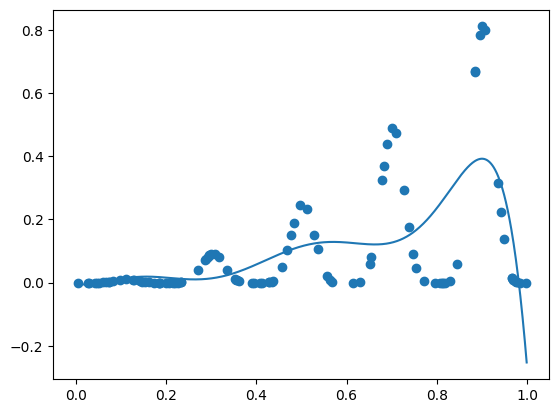

>x=0.0898, f()=0.00806, actual=0.00745
>x=0.899, f()=0.392, actual=0.806
>x=0.0358, f()=-0.00743, actual=2.96e-05
>x=0.725, f()=0.136, actual=0.333
>x=0.899, f()=0.428, actual=0.807
>x=0.621, f()=0.122, actual=0.00047
>x=0.084, f()=0.00804, actual=0.00581
>x=0.091, f()=0.0101, actual=0.00779
>x=0.901, f()=0.461, actual=0.811
>x=0.482, f()=0.109, actual=0.183
>x=0.199, f()=0.0131, actual=1.13e-14
>x=0.9, f()=0.488, actual=0.81
>x=0.9, f()=0.511, actual=0.81
>x=0.901, f()=0.531, actual=0.811
>x=0.901, f()=0.549, actual=0.811
>x=0.9, f()=0.564, actual=0.811
>x=0.862, f()=0.512, actual=0.244
>x=0.777, f()=0.228, actual=0.00106
>x=0.958, f()=0.325, actual=0.0495
>x=0.702, f()=0.0971, actual=0.491
>x=0.901, f()=0.554, actual=0.811
>x=0.753, f()=0.182, actual=0.0504
>x=0.904, f()=0.566, actual=0.809
>x=0.952, f()=0.378, actual=0.0915
>x=0.128, f()=0.022, actual=0.00887
>x=0.0193, f()=-0.0126, actual=2.68e-07
>x=0.901, f()=0.569, actual=0.811
>x=0.105, f()=0.0182, actual=0.0108
>x=0.755, f()=0

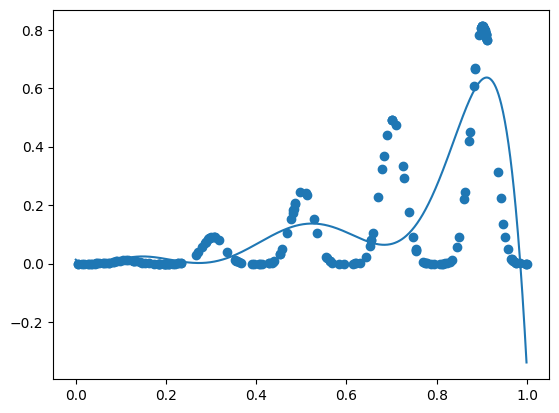

Best Result: x=0.901, y=0.811


In [7]:
from math import sin
from math import pi
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot

# objective function
def objective(x):
	return (x**2 * sin(5 * pi * x)**6.0)

# surrogate or approximation for the objective function
def surrogate(model, X):
    # catch any warning generated when making a prediction
    with catch_warnings():
        # ignore generated warnings
        simplefilter("ignore")
        return model.predict(X, return_std=True)

# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)
    # calculate the probability of improvement
    probs = norm.cdf((mu - best) / (std+1E-9))
    return probs

# optimize the acquisition function
def opt_acquisition(X, y, model):
    # random search, generate random samples
    Xsamples = random(100)
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    # calculate the acquisition function for each sample
    scores = acquisition(X, Xsamples, model)
    # locate the index of the largest scores
    ix = argmax(scores)
    return Xsamples[ix, 0]

# plot real observations vs surrogate function
def plot(X, y, model):
    # scatter plot of inputs and real objective function
    pyplot.scatter(X, y)
    # line plot of surrogate function across domain
    Xsamples = asarray(arange(0, 1, 0.001))
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    ysamples, _ = surrogate(model, Xsamples)
    pyplot.plot(Xsamples, ysamples)
    # show the plot
    pyplot.show()

# sample the domain sparsely with noise
X = random(100)
y = asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot before hand
plot(X, y, model)
# perform the optimization process
for i in range(100):
    # select the next point to sample
    x = opt_acquisition(X, y, model)
    # sample the point
    actual = objective(x)
    # summarize the finding
    est, _ = surrogate(model, [[x]])
    print(f">x={x:.3}, f()={est[0]:.3}, actual={actual:.3}")
    # add the data to the dataset
    X = vstack((X, [[x]]))
    y = vstack((y, [[actual]]))
    # update the model
    model.fit(X, y)

# plot all samples and the final surrogate function
plot(X, y, model)
# best result
ix = argmax(y)
print(f"Best Result: x={X[ix][0]:.3}, y={y[ix][0]:.3}")

Finally, the best input and its objective function score are reported. We know the optima has an input of 0.9 and an output of 0.810.